## Keras Sequantial Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile


Using TensorFlow backend.


### Define functions

In [2]:
def normalize_and_encode(dataframe):
    column_names_to_not_normalize = ['result']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp

    le = preprocessing.LabelEncoder()
    le.fit([ "H", "D", "A"])
    dataframe.loc[:,['result']]=le.transform(dataframe['result'])
    
    return dataframe

def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['result']).values
    y = dataframe[['result']].values
    return X,y


#def get_lr_schedule(train, batch_size):
    #lr_schedule = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
    #tf.keras.optimizers.schedules.InverseTimeDecay(
    #0.0001, # lr??
    #decay_steps=(len(train)//batch_size)*1000,
    #decay_rate=1,
    #staircase=False)
    #return lr_schedule

def get_optimizer(train, batch_size):
    return tf.keras.optimizers.SGD(lr=0.01, momentum=0.9) 
            #tf.keras.optimizers.Adam(get_lr_schedule(train, batch_size))


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name), # Jupyter Notebook
        #tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) # Google Colab
      ]

def compile_and_fit(model, name, X, y, validation_split, batch_size, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer(X, batch_size)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
     
    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    
    model.save("../model/%s.h5" %name) 
    
    return history

def plot_history(model_history):
	plt.plot(model_history.history['accuracy'])
	plt.plot(model_history.history['val_accuracy'])
	plt.title("%s accuracy" %model_history)
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	
	plt.plot(model_history.history['loss'])
	plt.plot(model_history.history['val_loss'])
	plt.title("%s loss" %model_history)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

### Read the sliding window + Preprocessing

In [3]:
df02 = pd.read_csv('../data/data_classification_results/sliding02_shots.csv', sep=',', index_col=0)
n02 = normalize_and_encode(df02)

train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)


6329 train examples
704 test examples


In [4]:
n02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,1,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,0,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,2,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,2,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048694,0.324626,0.174487,0.474766,0.243470,0.008116,0.016231,0.016231,0.040578,0.085214,0.482881,0.235354,0.454477,0.263759
7029,2,0.009960,0.017929,0.018427,0.014941,0.009960,0.024901,0.044822,0.104584,0.443238,0.234070,0.458179,0.229089,0.004980,0.019921,0.024901,0.034861,0.104584,0.517941,0.273911,0.313753,0.129485
7030,2,0.007617,0.015870,0.019044,0.012696,0.012696,0.016928,0.033855,0.033855,0.516293,0.249683,0.389336,0.211596,0.021160,0.008464,0.012696,0.063479,0.038087,0.355481,0.181972,0.499366,0.236987
7031,2,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055483,0.491416,0.245708,0.392341,0.198152,0.011889,0.011889,0.015852,0.043593,0.067372,0.408193,0.210041,0.483490,0.214004


### Define the model

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(3, activation='softmax')
])

In [6]:
size_histories['model02_H3_M'] = compile_and_fit(model02_H3_M, 'model02_H3_M', train_X02, train_y02, validation_split=validation_split,batch_size=BATCH_SIZE,max_epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                770       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                720       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3

### Load and test the model

In [7]:
model = load_model('../model/model02_H3_M.h5')
score = model.evaluate(test_X02, test_y02, verbose=3)
print("model02_H3_M")
print("Loss:", score[0])
print("Test Accuracy:", score[1])

model02_H3_M
Loss: 0.9703520184213464
Test Accuracy: 0.52982956


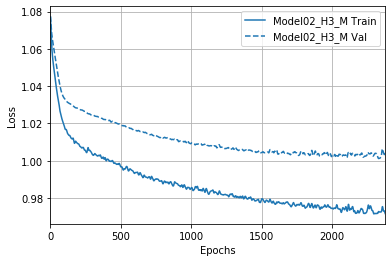

In [8]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

In [9]:
predictedResult = model.predict(test_X02, batch_size=1)

In [10]:
predictedResult

array([[0.01401841, 0.05068157, 0.93530005],
       [0.17895393, 0.2517701 , 0.569276  ],
       [0.5839974 , 0.2412223 , 0.17478022],
       ...,
       [0.17480266, 0.24784115, 0.5773562 ],
       [0.13220283, 0.21445084, 0.65334636],
       [0.1814804 , 0.25021115, 0.5683085 ]], dtype=float32)

In [11]:
ynew = model.predict_classes(test_X02)
ynew

array([2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,

In [12]:
test_y02

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)